<a href="https://colab.research.google.com/github/KoreTane/interesting/blob/main/ClusterC_2024_12_19_22_47_48.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import FloatType

files = {
    "df": "dbfs:/FileStore/tables/clusterizacao/online_retail_II.csv"
}
df = spark.read.csv(files["df"], inferSchema=True, header=True)
df.printSchema()
df.describe().show(truncate=False)
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)

+-------+-----------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|summary|Invoice          |StockCode         |Description                        |Quantity          |Price             |Customer ID       |Country    |
+-------+-----------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|count  |1067371          |1067371           |1062989                            |1067371           |1067371           |824364            |1067371    |
|mean   |537608.1499316233|29011.161534536903|21848.25   

In [ ]:
df = df.fillna({'Description': 'No description'})
df = df.fillna({'Customer ID': -1})

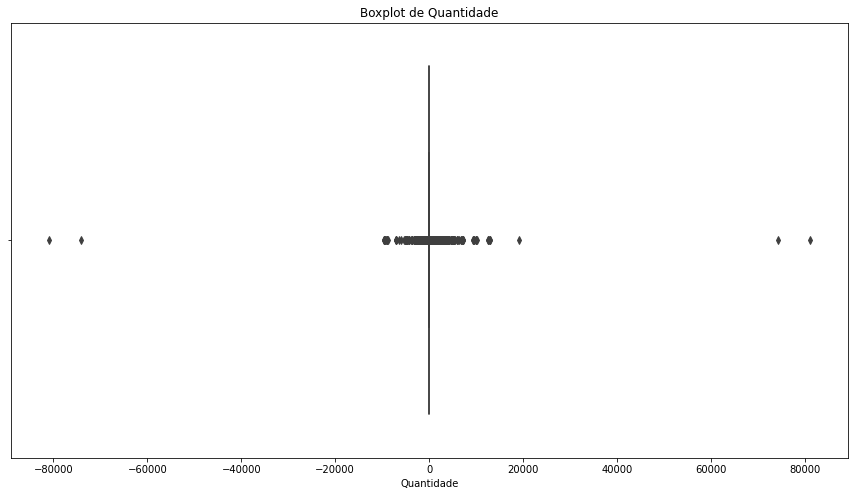

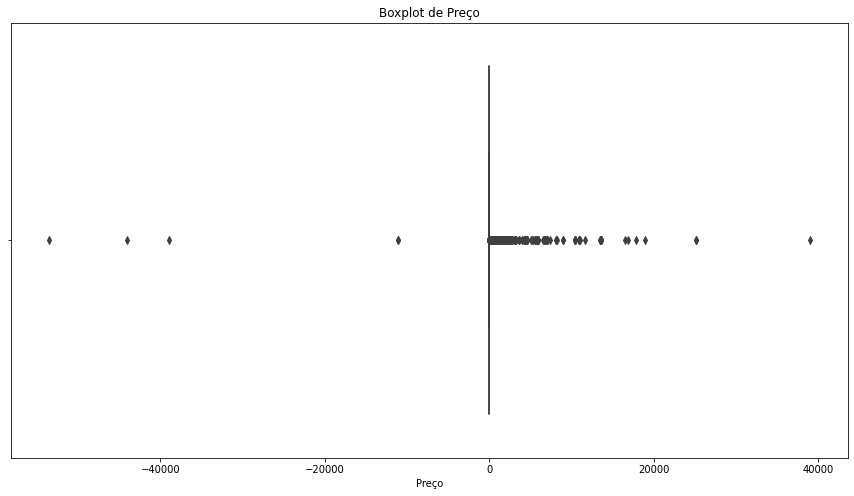

In [ ]:
# os dados estão concentrados próximos a média vamos explorar os outliers
quantity_pd = df.select("Quantity").toPandas()
price_pd = df.select("Price").toPandas()

# Boxplot de Quantidade
plt.figure(figsize=(15, 8))
sns.boxplot(x=quantity_pd["Quantity"])
plt.title("Boxplot de Quantidade")
plt.xlabel("Quantidade")
plt.show()

# Boxplot de Preço
plt.figure(figsize=(15, 8))
sns.boxplot(x=price_pd["Price"])
plt.title("Boxplot de Preço")
plt.xlabel("Preço")
plt.show()


In [ ]:
# Os outliears são principalmente provenientes de extornos e de compras anteriores ao período considerado, podemos E L I M I N A L O S para essa análisae

quantity_greater_20000 = df.filter(col("Quantity") > 10000).count()
quantity_less_20000 = df.filter(col("Quantity") < -10000).count()
price_greater_20000 = df.filter(col("Price") > 15000).count()
price_less_20000 = df.filter(col("Price") < -15000).count()

print("Quantidade de valores em Quantity > 20000:", quantity_greater_20000)
print("Quantidade de valores em Quantity < -20000:", quantity_less_20000)
print("Quantidade de valores em Price > 20000:", price_greater_20000)
print("Quantidade de valores em Price < -20000:", price_less_20000)

df = df.filter((col("Quantity") <= 20000) & (col("Quantity") >= -20000))

df = df.filter((col("Price") <= 20000) & (col("Price") >= -20000))

Quantidade de valores em Quantity > 20000: 9
Quantidade de valores em Quantity < -20000: 2
Quantidade de valores em Price > 20000: 7
Quantidade de valores em Price < -20000: 3


In [ ]:
df.describe().show(truncate=False)

+-------+------------------+------------------+-----------------------------------+-----------------+-----------------+------------------+-----------+
|summary|Invoice           |StockCode         |Description                        |Quantity         |Price            |Customer ID       |Country    |
+-------+------------------+------------------+-----------------------------------+-----------------+-----------------+------------------+-----------+
|count  |1067361           |1067361           |1067361                            |1067361          |1067361          |1067361           |1067361    |
|mean   |537608.1281153733 |29011.184801817722|21848.25                           |9.93898971388312 |4.693796408150182|11835.496342849327|null       |
|stddev |26662.442861686326|18822.979216152853|922.9197780233488                  |84.93917108076518|82.05849092717946|6597.3225838582075|null       |
|min    |489434            |10002             |  DOORMAT UNION JACK GUNS AND ROSES|-9600      

In [ ]:
df.groupBy(year("InvoiceDate").alias("Ano")).count().orderBy("count", ascending=False).show()

df.groupBy(month("InvoiceDate").alias("Mês")).count().orderBy("count", ascending=False).show()

df.groupBy(dayofmonth("InvoiceDate").alias("Dia")).count().orderBy("count", ascending=False).show()

df.groupBy("Country").count().orderBy("count", ascending=False).show()

df.groupBy("StockCode", "Description").agg(sum("Quantity").alias("TotalQuantity"), sum("Price").alias("TotalPrice")).orderBy("TotalQuantity", ascending=False).show()

df.groupBy("Customer ID").agg(countDistinct("Invoice").alias("TotalOrders"), sum("Price").alias("TotalSpent")).orderBy("TotalSpent", ascending=False).show()

correlation = df.select("Quantity", "Price").corr("Quantity", "Price")
print("Correlação entre Quantity e Price:", correlation)


+----+------+
| Ano| count|
+----+------+
|2010|522709|
|2011|499424|
|2009| 45228|
+----+------+

+---+------+
|Mês| count|
+---+------+
| 11|162726|
| 12|135756|
| 10|119839|
|  9| 92317|
|  3| 78259|
|  6| 76854|
|  7| 72900|
|  5| 72353|
|  8| 68590|
|  1| 66700|
|  4| 63972|
|  2| 57095|
+---+------+

+---+-----+
|Dia|count|
+---+-----+
|  7|47305|
|  8|45961|
|  6|40336|
| 17|39267|
|  5|39021|
| 18|38334|
| 14|37760|
|  4|37247|
|  1|37236|
| 21|37159|
| 11|37075|
| 10|36574|
|  9|36389|
| 28|35050|
| 22|35006|
| 15|33867|
| 25|33823|
| 16|33726|
|  2|32997|
| 13|32782|
+---+-----+
only showing top 20 rows

+---------------+------+
|        Country| count|
+---------------+------+
| United Kingdom|981320|
|           EIRE| 17866|
|        Germany| 17624|
|         France| 14330|
|    Netherlands|  5140|
|          Spain|  3811|
|    Switzerland|  3189|
|        Belgium|  3123|
|       Portugal|  2620|
|      Australia|  1913|
|Channel Islands|  1664|
|          Italy|  1534|
|  

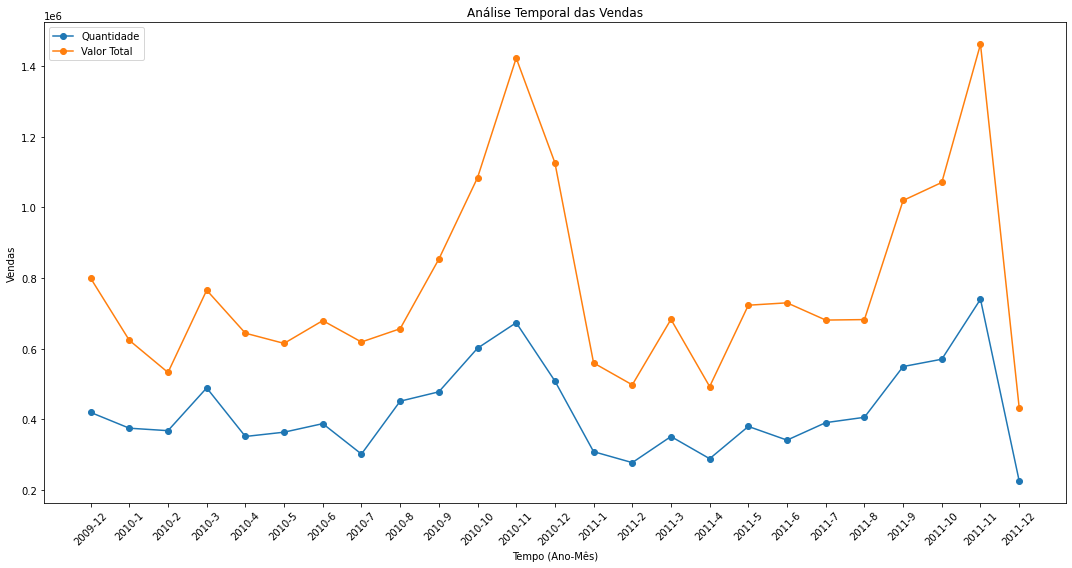

In [ ]:
# oaumento significativo de consumo sazonal das festividades de fim de ano. Há uma queda no inicio do verão, se deve em parte por ser um período de férias que consumidor efetua a compra presencial
temporal_df = df.withColumn("Year", year("InvoiceDate")).withColumn("Month", month("InvoiceDate"))
temporal_agg_df = temporal_df.groupBy("Year", "Month").agg(sum("Quantity").alias("TotalQuantity"), sum(expr("Quantity * Price")).alias("TotalValue")).orderBy("Year", "Month")
temporal_agg_pd = temporal_agg_df.toPandas()

plt.figure(figsize=(15, 8))

plt.plot(temporal_agg_pd["Year"].astype(str) + '-' + temporal_agg_pd["Month"].astype(str), temporal_agg_pd["TotalQuantity"], label="Quantidade", marker='o')

plt.plot(temporal_agg_pd["Year"].astype(str) + '-' + temporal_agg_pd["Month"].astype(str), temporal_agg_pd["TotalValue"], label="Valor Total", marker='o')

plt.title("Análise Temporal das Vendas")
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Vendas")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df = df.withColumn("TotalSpent", col("Quantity") * col("Price"))

recency_df = df.groupBy("Customer ID").agg(datediff(current_date(), max("InvoiceDate")).alias("Recency"))

frequency_df = df.groupBy("Customer ID").agg(count("Invoice").alias("Frequency"))

monetary_df = df.groupBy("Customer ID").agg(sum("TotalSpent").alias("Monetary"))

rfm_df = recency_df.join(frequency_df, "Customer ID").join(monetary_df, "Customer ID")

rfm_df = rfm_df.orderBy(col("Monetary").desc())

# Exibir RFM ordenado
rfm_df.show()

# Análise de Cohorts
cohort_df = df.groupBy("Customer ID").agg(min("InvoiceDate").alias("CohortDate"))
cohort_df = cohort_df.withColumn("CohortYear", year("CohortDate")).withColumn("CohortMonth", month("CohortDate"))

# Exibir Cohorts
cohort_df.show()

# Preparar dados para análise de cesta, garantindo que itens sejam únicos em cada transação
basket_data = df.groupBy("Invoice").agg(collect_set("StockCode").alias("Items"))

# Aplicar algoritmo FPGrowth
fpgrowth = FPGrowth(itemsCol="Items", minSupport=0.01, minConfidence=0.01)
model = fpgrowth.fit(basket_data)

# Exibir padrões frequentes
model.freqItemsets.orderBy(col("freq").desc()).show(truncate=False)

# Exibir regras de associação
model.associationRules.orderBy(col("confidence").desc()).show(truncate=False)


+-----------+-------+---------+------------------+
|Customer ID|Recency|Frequency|          Monetary|
+-----------+-------+---------+------------------+
|       -1.0|   4760|   243003|2750399.1100000357|
|    18102.0|   4760|     1068| 598215.2199999999|
|    14646.0|   4761|     3890| 523342.0699999998|
|    14156.0|   4769|     4130|         296564.69|
|    14911.0|   4761|    11613| 270248.5300000005|
|    17450.0|   4768|      448|233579.38999999998|
|    13694.0|   4763|     1558|190825.51999999996|
|    17511.0|   4762|     2134|171885.97999999998|
|    12415.0|   4784|      990|143269.29000000004|
|    16684.0|   4764|      749|         141502.25|
|    15061.0|   4763|      998|136391.47999999995|
|    15311.0|   4760|     4717|113513.07000000002|
|    13089.0|   4762|     3438|113214.19000000003|
|    17949.0|   4761|      183|          98895.59|
|    16029.0|   4798|      420|          91800.91|
|    14298.0|   4763|     2868|          90489.31|
|    15769.0|   4767|      243|

In [ ]:
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary"], outputCol="features")
rfm_features = assembler.transform(rfm_df)

kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(rfm_features)
clusters = model.transform(rfm_features)

clusters.show()

+-----------+-------+---------+------------------+--------------------+----------+
|Customer ID|Recency|Frequency|          Monetary|            features|prediction|
+-----------+-------+---------+------------------+--------------------+----------+
|       -1.0|   4760|   243003|2750399.1100000357|[4760.0,243003.0,...|         1|
|    18102.0|   4760|     1068| 598215.2199999999|[4760.0,1068.0,59...|         3|
|    14646.0|   4761|     3890| 523342.0699999998|[4761.0,3890.0,52...|         3|
|    14156.0|   4769|     4130|         296564.69|[4769.0,4130.0,29...|         4|
|    14911.0|   4761|    11613| 270248.5300000005|[4761.0,11613.0,2...|         4|
|    17450.0|   4768|      448|233579.38999999998|[4768.0,448.0,233...|         4|
|    13694.0|   4763|     1558|190825.51999999996|[4763.0,1558.0,19...|         4|
|    17511.0|   4762|     2134|171885.97999999998|[4762.0,2134.0,17...|         4|
|    12415.0|   4784|      990|143269.29000000004|[4784.0,990.0,143...|         4|
|   

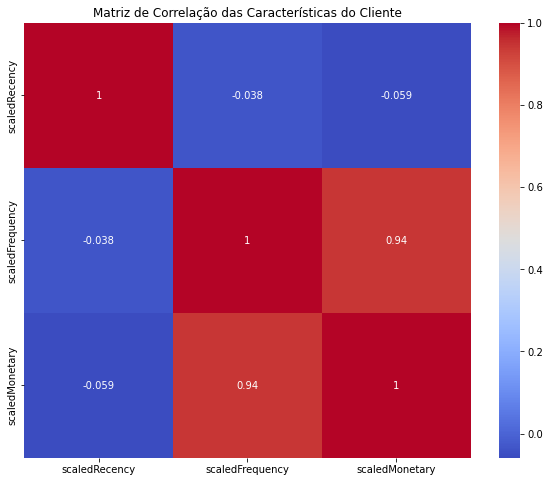

In [ ]:
from pyspark.sql.types import FloatType
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(rfm_features)
scaled_data = scaler_model.transform(rfm_features)

def extract_vector(vector):
    return [float(x) for x in vector]

extract_vector_udf = udf(extract_vector, ArrayType(FloatType()))

scaled_data = scaled_data.withColumn("scaledFeaturesArray", extract_vector_udf(col("scaledFeatures")))

scaled_data = scaled_data \
    .withColumn("scaledRecency", col("scaledFeaturesArray")[0]) \
    .withColumn("scaledFrequency", col("scaledFeaturesArray")[1]) \
    .withColumn("scaledMonetary", col("scaledFeaturesArray")[2])

scaled_columns = ["scaledRecency", "scaledFrequency", "scaledMonetary"]
scaled_pd = scaled_data.select(scaled_columns).toPandas()


correlation_matrix = scaled_pd.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação das Características do Cliente")
plt.show()
